### Getting Started

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

import shap

/tmp/ipykernel_22159/3033567457.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv("/home/kkyu/amr_ws/DL/IoT_Project/environment_test.csv")
data

,Date,Temperature (°C),Humidity (%),CO2 (PPM),PM-10 (μg/m3)
0,2024-03-09 21:24:14,23.8,24.0,144,41.66
1,2024-03-09 21:24:16,23.8,24.0,144,41.66
2,2024-03-09 21:24:18,23.8,24.0,145,32.86
3,2024-03-09 21:24:19,23.8,24.0,146,27.98
4,2024-03-09 21:24:21,23.8,24.0,144,28.95
...,...,...,...,...,...
128,2024-03-09 21:28:30,23.8,24.0,144,25.04
129,2024-03-09 21:28:32,23.8,24.0,143,16.25
130,2024-03-09 21:28:34,23.8,24.0,145,27.00
131,2024-03-09 21:28:36,23.8,24.0,145,16.25


In [3]:
# 'AQI' 컬럼 생성
data['AQI'] = 0

# for loop를 사용하여 각 행에 대한 AQI 값 계산 및 할당
for index, row in data.iterrows():
    PM_10_value = row['PM-10 (μg/m3)']
    AQI_value = ((100 - 51) / (80 - 31)) * (PM_10_value - 31) + 51
    data.at[index, 'AQI'] = AQI_value

data

/tmp/ipykernel_22159/1623584530.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '61.66' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[index, 'AQI'] = AQI_value


,Date,Temperature (°C),Humidity (%),CO2 (PPM),PM-10 (μg/m3),AQI
0,2024-03-09 21:24:14,23.8,24.0,144,41.66,61.66
1,2024-03-09 21:24:16,23.8,24.0,144,41.66,61.66
2,2024-03-09 21:24:18,23.8,24.0,145,32.86,52.86
3,2024-03-09 21:24:19,23.8,24.0,146,27.98,47.98
4,2024-03-09 21:24:21,23.8,24.0,144,28.95,48.95
...,...,...,...,...,...,...
128,2024-03-09 21:28:30,23.8,24.0,144,25.04,45.04
129,2024-03-09 21:28:32,23.8,24.0,143,16.25,36.25
130,2024-03-09 21:28:34,23.8,24.0,145,27.00,47.00
131,2024-03-09 21:28:36,23.8,24.0,145,16.25,36.25


In [4]:
# 'AQI_Bucket' 컬럼 생성 및 값 할당
data['AQI_Bucket'] = pd.cut(data['AQI'], bins=[0, 50, 100, 250, 500], labels=['Good', 'Moderate', 'Unhealthy', 'Very Unhealthy'])

data

,Date,Temperature (°C),Humidity (%),CO2 (PPM),PM-10 (μg/m3),AQI,AQI_Bucket
0,2024-03-09 21:24:14,23.8,24.0,144,41.66,61.66,Moderate
1,2024-03-09 21:24:16,23.8,24.0,144,41.66,61.66,Moderate
2,2024-03-09 21:24:18,23.8,24.0,145,32.86,52.86,Moderate
3,2024-03-09 21:24:19,23.8,24.0,146,27.98,47.98,Good
4,2024-03-09 21:24:21,23.8,24.0,144,28.95,48.95,Good
...,...,...,...,...,...,...,...
128,2024-03-09 21:28:30,23.8,24.0,144,25.04,45.04,Good
129,2024-03-09 21:28:32,23.8,24.0,143,16.25,36.25,Good
130,2024-03-09 21:28:34,23.8,24.0,145,27.00,47.00,Good
131,2024-03-09 21:28:36,23.8,24.0,145,16.25,36.25,Good


### Preprocessing

In [5]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Split df into X and y
    y = df['AQI']
    X = df.drop(['Date', 'AQI_Bucket', 'AQI'], axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [7]:
X_train


,Temperature (°C),Humidity (%),CO2 (PPM),PM-10 (μg/m3)
97,23.8,24.0,146,40.68
82,23.8,24.0,145,18.20
92,23.8,24.0,144,16.25
98,23.8,24.0,144,17.22
78,23.8,24.0,145,27.00
...,...,...,...,...
71,23.8,24.0,143,33.84
129,23.8,24.0,143,16.25
79,23.8,24.0,144,22.11
72,23.8,24.0,144,27.98


In [8]:
y_train

97     60.68
82     38.20
92     36.25
98     37.22
78     47.00
       ...  
71     53.84
129    36.25
79     42.11
72     47.98
37     44.07
Name: AQI, Length: 93, dtype: float64

In [9]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=1)

In [10]:
acc = model.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 99.89%


### Feature Impact With SHAP Values
- SHAP (SHapley Additive exPlanations) ->  모델의 예측을 설명
- 하나의 특성에 대한 중요도를 알기 위해 → 여러 특성들의 조합을 구성하고 → 해당 특성의 유무에 따른 평균적인 변화를 통해 값을 계산

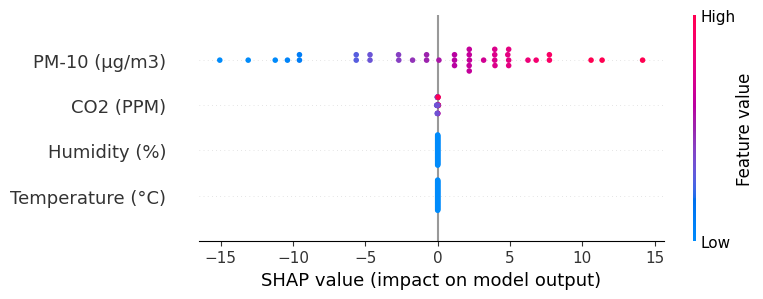

In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
